In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests, time, re, os

from bs4 import BeautifulSoup

from textblob import TextBlob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from datetime import datetime
from dateutil.relativedelta import relativedelta


In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dybae\AppData\Roaming\nltk_data...


True

In [2]:
# crawlling
beige_book = []
date_list = []

for year in range(2008, 2025):
    if year != 2024:
        url = f'https://www.federalreserve.gov/monetarypolicy/beigebook{year}.htm'
    else:
        url = 'https://www.federalreserve.gov/monetarypolicy/beige-book-default.htm'
    res = requests.get(url)
    res.raise_for_status()
    soup = BeautifulSoup(res.text, 'lxml')
    tbody = soup.find('tbody')
    htmls = tbody.find_all('a')
    
    for html in htmls:
        if '.htm' in html['href']:
            try:
                url_a = html['href'] 
                if 'default' not in url_a:
                    if year not in range(2011,2017):
                        url_a = 'https://www.federalreserve.gov' + url_a + '?summary'
                    res_a = requests.get(url_a)
                    soup_a = BeautifulSoup(res_a.text, 'lxml')
                    div = soup_a.find('div', {'id': 'div_summary'})
                    raw_text = div.text.replace('\n', ' ').replace('\r', '').replace('\t', '')
                    footer = raw_text.find('Return')
                    text = raw_text[:footer].strip()
                    date = soup_a.find('h1', {'class': 'border'}).text.split('- ')[-1]
                else:
                    res_a = requests.get(url_a)
                    soup_a = BeautifulSoup(res_a.text, 'lxml')
                    td = soup_a.find_all('td')[4]
                    raw_text = td.text.replace('\n', ' ').replace('\r', '').replace('\t', '')
                    footer = raw_text.find('Return')
                    text = raw_text[:footer].strip()
                    date = soup_a.find('font').text
            except:
                url_full = 'https://www.federalreserve.gov' + html['href']
                res_full = requests.get(url_full)
                soup_full = BeautifulSoup(res_full.text, 'lxml')
                date = soup_full.find('div', {'class': 'page-title'}).text.split(' - ')[-1].strip()
                
                url_a = url_full.replace('.htm', '-summary.htm')
                if year == 2024:
                    url_a = url_full
                if url_a == 'https://www.federalreserve.gov/monetarypolicy/beigebook20230531-summary.htm':
                    url_a = 'https://www.federalreserve.gov/monetarypolicy/beigebook202305-summary.htm' 

                res_a = requests.get(url_a)
                soup_a = BeautifulSoup(res_a.text, 'lxml')
                div = soup_a.find('div', {'id': 'article'})
                raw_text = div.text.replace('\n', ' ').replace('\r', '').replace('\t', '')
                footer = raw_text.find('Return')
                text = raw_text[:footer].strip()
    
            beige_book.append(text)
            date_list.append(date)
    print(year)

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [3]:
date_list

['January 16, 2008',
 'March 5, 2008',
 'April 16, 2008',
 'June 11, 2008',
 'July 23, 2008',
 'September 3, 2008',
 'October 15, 2008',
 'December 3, 2008',
 'January 14, 2009',
 'March 4, 2009',
 'April 15, 2009',
 'June 10, 2009',
 'July 29, 2009',
 'September 9, 2009',
 'October 21, 2009',
 'December 2, 2009',
 'January 13, 2010',
 'March 3, 2010',
 'April 14, 2010',
 'June 9, 2010',
 'July 28, 2010',
 'September 8, 2010',
 'October 20, 2010',
 'December 1, 2010',
 'January 12, 2011',
 'March 2, 2011',
 'April 13, 2011',
 'June 8, 2011',
 'July 27, 2011',
 'September 7, 2011',
 'October 19, 2011',
 'November 30, 2011',
 'January 11, 2012',
 'February 29, 2012',
 'April 11, 2012',
 'June 6, 2012',
 'July 18, 2012',
 'August 29, 2012',
 'October 10, 2012',
 'November 28, 2012',
 'January 16, 2013',
 'March 6, 2013',
 'April 17, 2013',
 'June 5, 2013',
 'July 17, 2013',
 'September 4, 2013',
 'October 16, 2013',
 'December 4, 2013',
 'January 15, 2014',
 'March 5, 2014',
 'April 16, 2

In [4]:
len(beige_book), len(date_list)

(133, 133)

In [5]:
df = pd.DataFrame([beige_book, date_list]).T
df.columns = ['beige_book', 'date']

# 데이터프레임 날짜 전처리

def convert_date(date_str):
    try:
        date = pd.to_datetime(date_str, format='%B %d, %Y')
    except ValueError:
        try:
            date = pd.to_datetime(date_str, format='%B %Y')
        except ValueError:
            date = pd.NaT
    return date

df['date'] = df['date'].apply(convert_date)
df['date'] = df['date'].dt.strftime('%B %Y')
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# 모든 달의 데이터 생성 함수
def fill_missing_months(df):
    start_date = df['date'].min()
    end_date = df['date'].max()

    all_months = pd.date_range(start=start_date, end=end_date, freq='MS')

    new_data = []
    last_known_row = None

    for month in all_months:
        if month in df['date'].values:
            last_known_row = df[df['date'] == month].iloc[0]
        new_row = last_known_row.copy()
        new_row['date'] = month
        new_data.append(new_row)

    result_df = pd.DataFrame(new_data).reset_index(drop=True)
    return result_df

df = fill_missing_months(df)

/var/folders/2v/cr2_y57x1kbfbs1sfsbb5vwc0000gn/T/ipykernel_13205/944146570.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
/var/folders/2v/cr2_y57x1kbfbs1sfsbb5vwc0000gn/T/ipykernel_13205/944146570.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [6]:
# 감성 분석 # sentiment: 전체적인 감정을 나타내는 점수, -1에서 1 사이의 값으로, 값이 클수록 긍정적인 감정을 나타냅니다.

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df[['neg', 'neu', 'pos', 'sentiment']] = df['beige_book'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

# del df['neg'], df['neu'], df['pos'] # 자유롭게 사용하시면 됩니다.

df

,beige_book,date,neg,neu,pos,sentiment
0,Prepared at the Federal Reserve Bank of Atlant...,2008-01-01,0.081,0.798,0.121,0.9983
1,Prepared at the Federal Reserve Bank of Atlant...,2008-02-01,0.081,0.798,0.121,0.9983
2,Prepared at the Federal Reserve Bank of Boston...,2008-03-01,0.070,0.831,0.099,0.9977
3,Prepared at the Federal Reserve Bank of New Yo...,2008-04-01,0.064,0.842,0.094,0.9970
4,Prepared at the Federal Reserve Bank of New Yo...,2008-05-01,0.064,0.842,0.094,0.9970
...,...,...,...,...,...,...
194,National Summary Overall Economic Activity Eco...,2024-03-01,0.056,0.797,0.147,0.9991
195,National Summary Overall Economic Activity Ove...,2024-04-01,0.068,0.807,0.126,0.9974
196,National Summary Overall Economic Activity Nat...,2024-05-01,0.076,0.783,0.141,0.9982
197,National Summary Overall Economic Activity Nat...,2024-06-01,0.076,0.783,0.141,0.9982


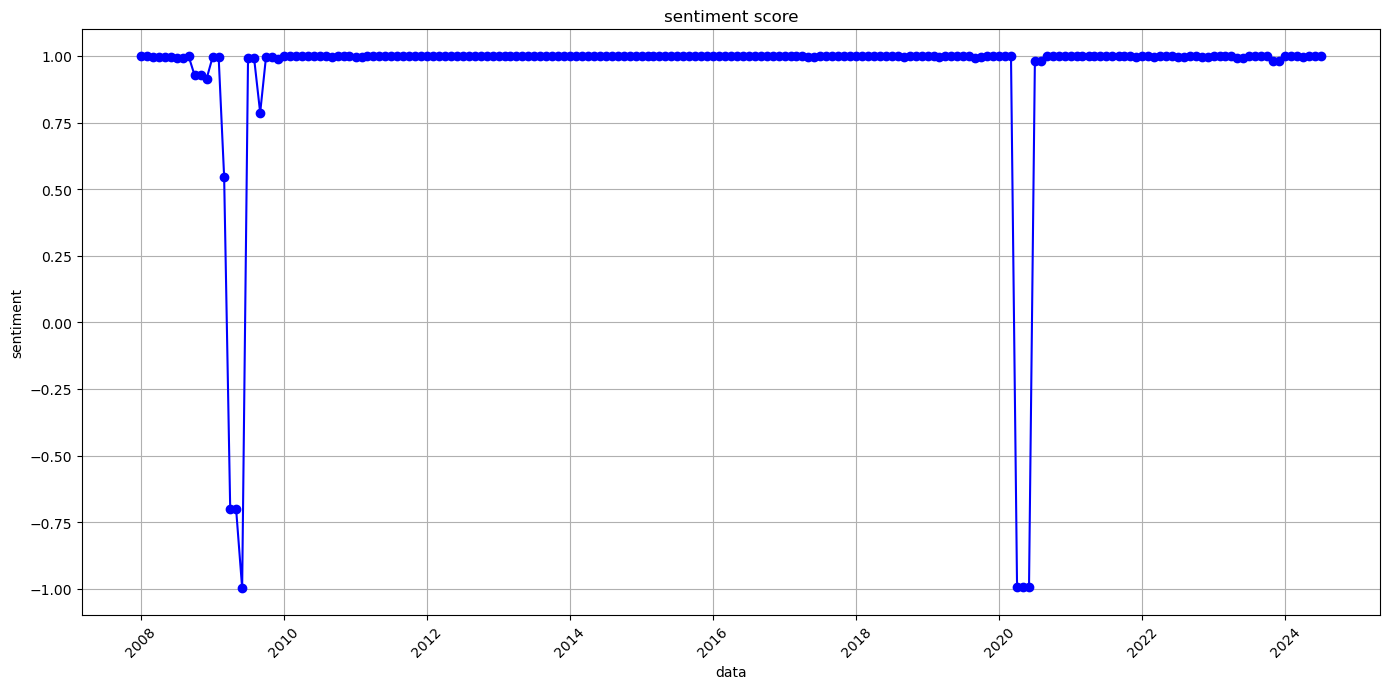

In [7]:
# 감성 분석 점수 시각화

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['sentiment'], marker='o', linestyle='-', color='b')
plt.title('sentiment score')
plt.xlabel('data')
plt.ylabel('sentiment')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# 파일 저장
df.to_excel('./../Fed2_dataset/beige_book_2008_2024.xlsx', index=False)